ref: https://www.kaggle.com/meddulla/predicting-survival

Categorical encoding: https://pbpython.com/categorical-encoding.html

Feature selection: https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b
https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

# Trabalho Final Data Mining

*Turma Bi Master 2019.3*

**Professora**: Manoela Kohler

**Aluno**: Rodrigo Moreira Araújo

**Matrícula**: 192.190.075

## Índice:

1. [Descrição do problema](#descricao)
2. [Análise Exploratória](#analise-exp)
    1. [Importação](#2-importacao)
    2. [Criação dos DataFrames](#2-criacao)
3. [Valores faltantes](#faltantes)
    1. [Categóricos](#3-categoricos)
    2. [Numéricos](#3-numericos)
4. [Atributos desnecessários](#desnecessarios)

## 1. Descrição do problema <a class="anchor" id="descricao"></a>

**Problema de classificação**

* 27 atributos numéricos e categóricos que descrevem o estado de saúde de cavalos; 
* Três classes de saída que indicam o que aconteceu com o cavalo: morreu, viveu ou se foi submetido à eutanásia. A ideia é prever se um cavalo pode sobreviver ou não baseado nas condições médicas passadas.

## 2. Análise exploratória dos dados <a class="anchor" id="analise-exp"></a>

#### A. Importação dos módulos necessários <a class="anchor" id="2-importacao"></a>

In [90]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Para a seleção de atributos relevantes
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#### B. Criação dos DataFrames de treino (df) e  teste (df_test) <a class="anchor" id="2-criacao"></a>

In [91]:
# Criação dos DataFrames de treino e teste

df = pd.read_csv("horse.csv")
df_test = pd.read_csv("horseTest.csv")

df.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,no,adult,530101,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,...,45.0,8.4,NaN,NaN,died,no,11300,0,0,no
1,yes,adult,534817,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,...,50.0,85.0,cloudy,2.0,euthanized,no,2208,0,0,no
2,no,adult,530334,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,...,33.0,6.7,NaN,NaN,lived,no,0,0,0,yes
3,yes,young,5290409,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,...,48.0,7.2,serosanguious,5.3,died,yes,2208,0,0,yes
4,no,adult,530255,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,...,74.0,7.4,NaN,NaN,died,no,4300,0,0,no


## 3. Verificação de valores faltantes (*missing values*) <a class="anchor" id="faltantes"></a>

In [92]:
# Extrai o número total de linhas do Dataframe
total_lines = df.shape[0]

# Avalia o número de linhas preenchidas por coluna
cols_count = df.count(axis=0)

# Seleciona apenas as colunas com dados faltantes
missing_cols = cols_count[cols_count != total_lines]

# Verifica o tipo das colunas com dados faltantes
col_types = df[missing_cols.index].dtypes

# Segrega as colunas de float e de string
float_cols = col_types[col_types == "float64"]
str_cols = col_types[col_types == "object"]

# Lista de colunas com total de valores
missing_cols

rectal_temp              239
pulse                    275
respiratory_rate         241
temp_of_extremities      243
peripheral_pulse         230
mucous_membrane          252
capillary_refill_time    267
pain                     244
peristalsis              255
abdominal_distention     243
nasogastric_tube         195
nasogastric_reflux       193
nasogastric_reflux_ph     53
rectal_exam_feces        197
abdomen                  181
packed_cell_volume       270
total_protein            266
abdomo_appearance        134
abdomo_protein           101
dtype: int64

#### Preenchimento dos valores faltantes das colunas categóricas <a class="anchor" id="3-categoricos"></a>

In [93]:
# Extrai a moda de cada uma das colunas de string com valores faltantes
col_modes = df[str_cols.index].mode()
# df[col_modes.columns].fillna(col_modes.iloc[0], axis=0)
df[col_modes.columns] = df[col_modes.columns].fillna(col_modes.iloc[0], axis=0)
df[col_modes.columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 12 columns):
temp_of_extremities      299 non-null object
peripheral_pulse         299 non-null object
mucous_membrane          299 non-null object
capillary_refill_time    299 non-null object
pain                     299 non-null object
peristalsis              299 non-null object
abdominal_distention     299 non-null object
nasogastric_tube         299 non-null object
nasogastric_reflux       299 non-null object
rectal_exam_feces        299 non-null object
abdomen                  299 non-null object
abdomo_appearance        299 non-null object
dtypes: object(12)
memory usage: 28.1+ KB


#### Preenchimento dos valores faltantes das colunas numéricas  <a class="anchor" id="3-numericos"></a>

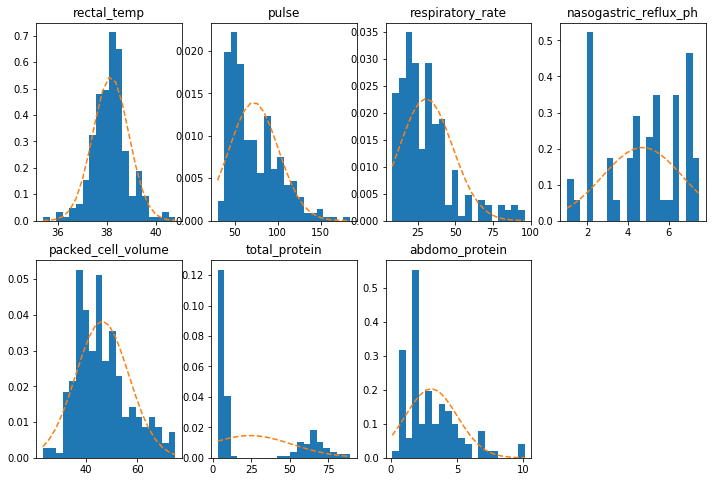

In [94]:
# Análise das distribuições dos valores faltantes do tipo float
def plot_histograms(dataframe, cols):
    fig = plt.figure(figsize=(12,8))
    for i, col in enumerate(cols.index):
        plt.subplot(2, 4, i+1)
        plt.title(col)
        vals = np.array(dataframe[col].copy().dropna().values)
        # Plota o histograma
        nhist, bins, patches = plt.hist(vals, bins=20, density=True)
        # Cálculo dos parâmetros da distribuição normal
        mean = vals.mean() 
        std = vals.std()  
        y = ((1/(np.sqrt(2*np.pi)*std))*np.exp(-0.5*(1/std*(bins-mean))**2))
        # Plota a gaussiana que melhor ajusta o histograma
        plt.plot(bins, y, '--')

plot_histograms(df, float_cols)

A análise dos histogramas permite concluir que as colunas `rectal_temp`, `packed_cell_volume`, `pulse` e `respiratory_rate` se aproximam razoavelmente de distribuições normais. Assim, os valores faltantes podem ser preenchidos com a mediana.

Para as outras três colunas (`nasograstric_reflux_ph`, `total_protein`, `abdomo_protein`), será usada a moda.

In [95]:
normal_float_cols = ["rectal_temp","packed_cell_volume","pulse","respiratory_rate"]
other_float_cols = ["nasogastric_reflux_ph", "total_protein", "abdomo_protein"]
for col in normal_float_cols:
    df[col] = df[col].fillna(df[col].median())
for col in other_float_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

df[float_cols.index].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 7 columns):
rectal_temp              299 non-null float64
pulse                    299 non-null float64
respiratory_rate         299 non-null float64
nasogastric_reflux_ph    299 non-null float64
packed_cell_volume       299 non-null float64
total_protein            299 non-null float64
abdomo_protein           299 non-null float64
dtypes: float64(7)
memory usage: 16.4 KB


In [96]:
# Confirmando que todo o dataframe encontra-se preenchido
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 28 columns):
surgery                  299 non-null object
age                      299 non-null object
hospital_number          299 non-null int64
rectal_temp              299 non-null float64
pulse                    299 non-null float64
respiratory_rate         299 non-null float64
temp_of_extremities      299 non-null object
peripheral_pulse         299 non-null object
mucous_membrane          299 non-null object
capillary_refill_time    299 non-null object
pain                     299 non-null object
peristalsis              299 non-null object
abdominal_distention     299 non-null object
nasogastric_tube         299 non-null object
nasogastric_reflux       299 non-null object
nasogastric_reflux_ph    299 non-null float64
rectal_exam_feces        299 non-null object
abdomen                  299 non-null object
packed_cell_volume       299 non-null float64
total_protein            299 non-nul

#### C. Tratamento de colunas categóricas <a class="anchor" id="3-categoricos"></a>

In [97]:
# Extração das colunas que possuem dados categóricos
categorical_cols = df.select_dtypes(include=['object']).columns

# for col in categorical_cols:
#     print(col)
#     print(df[col].value_counts(), "\n")

As colunas `surgery`, `surgical_lesion`, `cp_data`, `age`, `capillary_refill_time`, `temp_of_extremities`, `peripheral_pulse`, `capillary_refill_time`, `pain`, `peristalsis`, `abdominal_distention`, `nasogastric_tube`, `nasogastric_reflux`, `rectal_exam_feces`, `mucous_membrane`, `abdomen`, `abdomo_appearance` possuem valores categóricos.

Porém, a sua conversão pode ser feita para valores numéricos de forma diferente:
* **Colunas `surgery`, `surgical_lesion`, `cp_data`**: contém apenas `yes` e `no`, então podem ser diretamente convertidas para 0 e 1;
* **Colunas `age`, `capillary_refill_time`, `temp_of_extremities`, `peripheral_pulse`, `capillary_refill_time`, `pain`, `peristalsis`, `abdominal_distention`, `nasogastric_tube`, `nasogastric_reflux`, `rectal_exam_feces`**: contém valores sequenciais, então podem ser convertidas para inteiros em sequência;
* **Colunas `mucous_membrane`, `abdomen`, `abdomo_appearance`**: contém categorias e serão convertidas com *One Hot Encoding*

In [98]:
for curr_df in [df, df_test]:
    yes_no_cols = ["surgery", "surgical_lesion", "cp_data"]
    curr_df[yes_no_cols] = curr_df[yes_no_cols].replace({"yes":1,"no":0})
    curr_df["age"] = curr_df["age"].replace({"young":0, "adult":1})
    curr_df["capillary_refill_time"] = curr_df["capillary_refill_time"].replace({1:0, 2:1})

    curr_df["temp_of_extremities"] = curr_df["temp_of_extremities"].replace({"cold":0, "normal":1, "cool":2, "warm":3})
    curr_df["peripheral_pulse"] = curr_df["peripheral_pulse"].replace({"absent":0, "reduced":1, "normal":2, "increased":3})
    curr_df["capillary_refill_time"] = curr_df["capillary_refill_time"].replace({"less_3_sec":0, "3":1, "more_3_sec":2})
    curr_df["pain"] = curr_df["pain"].replace({"alert":0, "depressed":1, "mild_pain":2, "severe_pain":3, "extreme_pain":4})
    curr_df["peristalsis"] = curr_df["peristalsis"].replace({"hypermotile":0, "normal":1, "hypomotile":2, "absent":3})
    curr_df["abdominal_distention"] = curr_df["abdominal_distention"].replace({"none":0, "moderate":1, "slight":2, "severe":3})
    curr_df["nasogastric_tube"] = curr_df["nasogastric_tube"].replace({"none":0, "slight":1, "significant":2})
    curr_df["nasogastric_reflux"] = curr_df["nasogastric_reflux"].replace({"none":0, "less_1_liter":1, "more_1_liter":2})
    curr_df["rectal_exam_feces"] = curr_df["rectal_exam_feces"].replace({"absent":0, "decreased":1, "normal":2, "increased":2})

    # Como o objetivo é avaliar se o cavalo sobreviveu, os valores died e euthanized serão tratados indistintamente
    curr_df["outcome"] = curr_df["outcome"].replace({"died":0, "euthanized":0, "lived":1})

In [99]:
# Criando One Hot Encoding das variáveis categóricas restantes: mucous_membrane, abdomen, abdomo_appearance
df = pd.get_dummies(df)
df_test = pd.get_dummies(df_test)

In [107]:
# Garantindo a consistência das colunas criadas com One Hot Encoding entre os DataFrames de treino e teste

train_cols = df.columns
test_cols = df_test.columns

train_cols == test_cols

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

## 4. Atributos desnecessários  <a class="anchor" id="desnecessarios"></a>

In [113]:
all_cols = list(df.columns.values)
all_cols.remove("outcome")
x_cols = all_cols

X = df[x_cols]
y = df["outcome"]    #target column i.e price range#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(100,'Score'))  #print 10 best features

                              Specs         Score
2                   hospital_number  2.308449e+06
20                         lesion_1  1.504957e+04
21                         lesion_2  1.399735e+04
22                         lesion_3  1.501624e+03
4                             pulse  3.844224e+02
17                    total_protein  2.326806e+02
16               packed_cell_volume  1.029287e+02
8             capillary_refill_time  4.429167e+01
9                              pain  2.662855e+01
13               nasogastric_reflux  1.661998e+01
27      mucous_membrane_normal_pink  1.451409e+01
15                rectal_exam_feces  1.388812e+01
37  abdomo_appearance_serosanguious  1.384026e+01
25       mucous_membrane_bright_red  1.310119e+01
10                      peristalsis  1.179873e+01
5                  respiratory_rate  1.126180e+01
19                  surgical_lesion  9.735875e+00
28    mucous_membrane_pale_cyanotic  8.960871e+00
11             abdominal_distention  8.364312e+00


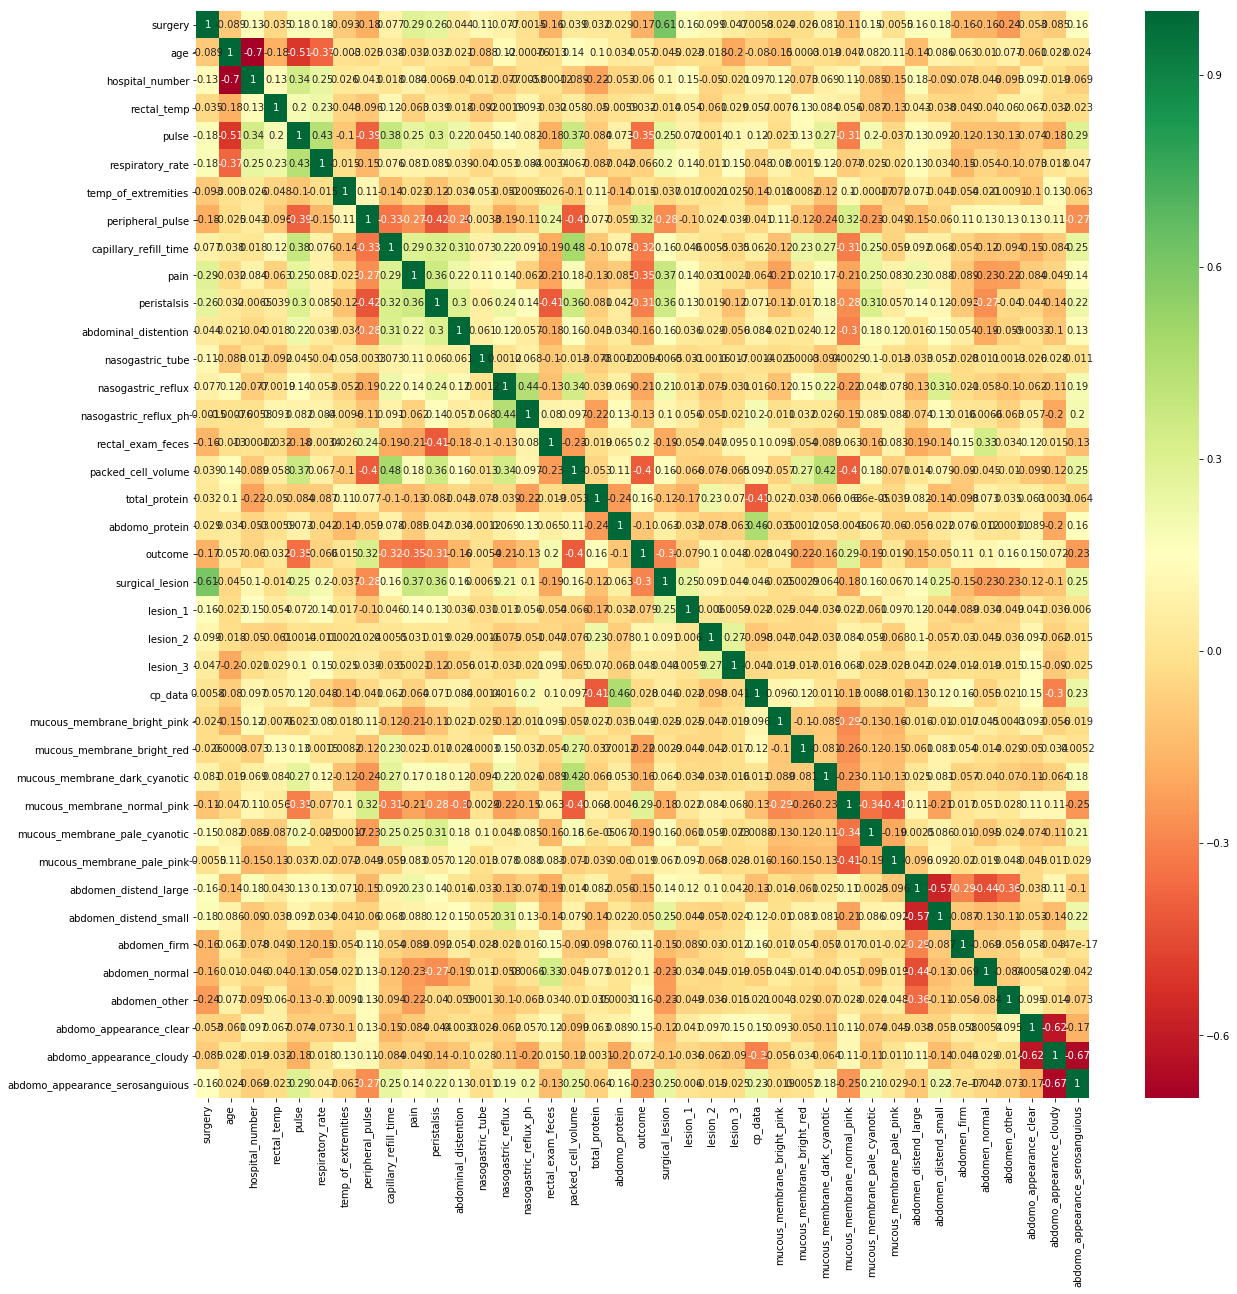

In [116]:
import seaborn as sns
#get correlations of each features in dataset
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")